<a href="https://colab.research.google.com/github/hfoffani/HF-fastai/blob/main/nb30_iula_blurr_blearner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install -Uqq transformers datasets tqdm
!pip install -Uqq ohmeow-blurr

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import os

import pandas as pd

from transformers import AutoModelForSequenceClassification

from blurr.utils import BLURR
from blurr.data.core import HF_TextBlock
from blurr.modeling.core import Blearner

from fastai.text.all import *


### Leer Corpus

In [27]:
co_df = pd.read_csv('/content/drive/MyDrive/iula-es.csv')
num_labels = co_df['label'].nunique()
co_df

,label,sentence,is_valid
0,economía,LOS POSTULADOS DE LA ECONOMÍA CLÁSICA,True
1,economía,"La mayor parte de los tratados sobre la teoría del valor y de la producción se refieren, en primer término, a la distribución de un volumen dado de recursos empleados en diferentes usos, y a las condiciones que, supuesta la ocupación de esta cantidad de recursos, determinen su remuneración relativa y el relativo valor de sus productos [1]",False
2,economía,"También se ha sujetado con frecuencia a un procedimiento descriptivo lo relativo al monto de los recursos disponibles (entendiendo por tales el volumen de población susceptible de tomar empleo), los límites de la riqueza natural y el equipo de producción acumulado; pero rara vez se ha examinado detenidamente en la teoría pura, la explicación de lo que determina la ocupación real de los recursos disponibles.",False
3,economía,"Decir que no se ha considerado en absoluto, seria absurdo, por supuesto; porque todo estudio sobre los altibajos de la ocupación, que han sido muchos, ha tenido que ver con el tema.",False
4,economía,"No quiero decir que se haya pasado por alto, sino que la teoría fundamental en que descansa se ha creído tan sencilla y evidente que casi no había para qué mencionarla [2]",False
...,...,...,...
52350,medicina,Diarrea.,True
52351,medicina,Debilidad.,False
52352,medicina,Gusto alterado.,False
52353,medicina,Parestesias peribucales.,False


### Modelar

In [28]:

# pretrained_model_name = "distilbert-base-uncased"
# pretrained_model_name = "bert-base-uncased"
# pretrained_model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
pretrained_model_name = "distilroberta-base"

In [29]:
model_cls = AutoModelForSequenceClassification

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(
    pretrained_model_name,
    model_cls=model_cls,
    config_kwargs={'num_labels': num_labels})

In [30]:
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock)
dblock = DataBlock(blocks=blocks,
                   get_x=ColReader('sentence'),
                   get_y=ColReader('label'),
                   splitter=ColSplitter())

dls = dblock.dataloaders(co_df, bs=4, val_bs=8)

In [31]:
dls.show_batch(dataloaders=dls)

,text,category
0,"En una economía estacionaria quizá no valiera la pena mencionar todo esto, ya que en cada año los márgenes de tolerancia para la depreciación, con respecto a las casas viejas, quedarían compensados exactamente por las casas nuevas que se construyeran en sustitución de las que llegan al fin de su vida cada año; pero tales factores pueden ser de mucha importancia en una economía no estática, especialmente durante el periodo que sigue de inmediato a un vigoroso brote de inversión de capital a largo plazo; porque en tales circunstancias gran parte de las nuevas partidas de inversión puede ser absorbida por las mayores reservas financieras que hacen los empresarios para reparar y renovar el equipo de producción existente, el cual, aunque se desgasta con el tiempo, todavía no ha llegado a la fecha en que deben hacerse gastos que puedan aproximarse al total de la reserva financiera que se aparta; con la consecuencia de que los ingresos no pueden subir por encima de un nivel lo bastante bajo para corresponder a un total pequeño de inversión neta.",economía
1,"A partir de 1821 vagabundeó por el Canadá, los Estados Unidos y otros países, incluidas las islas Hawai, realizando en todas partes rudos trabajos (los dos empleos que tuvo de maestro elemental fueron los más adecuados a su carácter), hasta que, poco antes de su muerte, quedó varado, ya rotos los mástiles, en el puerto de una casa amiga, en Clifton, Staten Island.",economía
2,"Con el fin de acelerar los descubrimientos sobre los mecanismos fisiopatológicos que llevan al desarrollo de enfermedades cardiovasculares y de traducir estos resultados en prevención y tratamientos, se estimulará la investigación multidisciplinar asociando la competencia de médicos y científicos de formación diferente en la investigación cardiovascular fundamental y clínica y en la genética molecular.",medicina
3,"Por este motivo, los hechos propios de la situación presente entran, desproporcionadamente en cierto sentido, en la formación de nuestras expectativas a largo plazo, siendo nuestra costumbre fijarnos en la situación actual, para proyectarla en el futuro, modificándola únicamente según los motivos más o menos definidos que tengamos para esperar una variación.",economía


In [32]:
b = dls.one_batch()

len(b), b[0]['input_ids'].shape, b[1].shape, dls.c

(2, torch.Size([4, 343]), torch.Size([4]), 5)

In [33]:
learn = Blearner(dls, hf_model,
                 metrics=[F1Score(average=None)])
learn = learn.to_fp16()
learn.unfreeze()


In [34]:
learn.summary()

HF_BaseModelWrapper (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 343 x 768       
Embedding                                 38603520   True      
Embedding                                 394752     True      
Embedding                                 768        True      
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     True      
Linear                                    590592     True      
Linear                                    590592     True      
Dropout                                                        
Linear                                    590592     True      
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
            

### Entrenar

SuggestedLRs(valley=0.00019054606673307717)

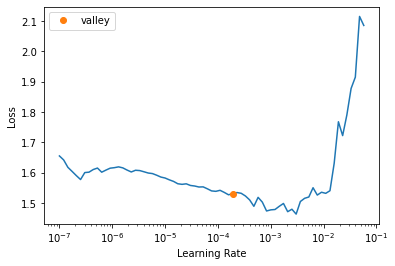

In [35]:
learn.lr_find()

In [36]:
learn.fit_one_cycle(1, lr_max=3e-3)

epoch,train_loss,valid_loss,f1_score,time
0,1.193148,1.183186,[0. 0. 0. 0.6754791 0. ],12:03


In [37]:
learn.show_results(learner=learn, max_n=5)

,text,category,target
0,"Quedan reservadas, en todo caso, a las Fuerzas y Cuerpos de Seguridad del Estado bajo la dependencia del Gobierno los servicios policiales de carácter extracomunitario y supracomunitario como la vigilancia de puertos, aeropuertos, costas y fronteras, aduanas, control de entrada y salida del territorio nacional de españoles y extranjeros, régimen general de extranjería, extradición y expulsión, emigración e inmigración, pasaportes, documento nacional de identidad, trafico, armas y explosivos, resguardo fiscal del Estado, contrabando y fraude fiscal y las demás funciones que directamente les encomienda el artículo 104 de la Constitución [19] y las que les atribuya la Ley orgánica que lo desarrolle.",legal,medicina
1,"El espectáculo de los mercados de inversión modernos me ha llevado algunas veces a concluir que la compra de una inversión debe ser permanente e indisoluble, como el matrimonio, excepto por motivo de muerte o de otra causa grave, y esto será un remedio útil para nuestros males contemporáneos; porque tal cosa forzaría a los inversionistas a dirigir su atención solamente a las oportunidades a largo plazo; pero un pequeño examen de este recurso nos lleva a un dilema, y nos muestra cómo la liquidez de los mercados de inversión a menudo facilita, aunque algunas veces impide, el curso de las nuevas inversiones.",economía,medicina
2,"Con frecuencia, de amplias extensiones me habían hablado de igual forma que Homero gobernó sus posesiones; pero nunca antes respiré su tranquilidad hasta que escuché a Chapman hablando fuerte y claro: En aquel momento me sentí como un observador de los cielos que ha descubierto un nuevo planeta en el firmamento; o como el fornido Cortés, cuando con sus ojos de águila observaba firmemente al Pacífico, y todos sus hombres se miraban entre sí haciéndose suposiciones entusiastas.",tecnología,medicina
3,Sin la existencia de asociaciones ecologistas la salvaguarda del patrimonio común no se garantiza como lo reflejan con crudeza las declaraciones del ex director de la Central de Inteligencia Americana (CIA) cuando afirmaba en la Conferencia Mundial de la Energía celebrada en Madrid en octubre de 1992 que para el gobierno de Estados Unidos es mucho mas sencillo y eficaz desencadenar una guerra en Oriente Medio que decretar medidas de ahorro de combustibles.,ambiente,medicina
4,"A menudo se ha negado que los argumentos escolásticos fueran de naturaleza analítica, por la razón de que esas argumentaciones no pueden haber sido sino argumentos de autoridad: puesto que estaban sometidos a la autoridad del papa, aquellos intelectuales no tenían más método posible para asentar o refutar una proposición que el de aducir en favor o en contra suyo autoridades literarias reconocidas por la suprema autoridad pontificia.",economía,medicina


### Evaluar

In [38]:
val_res = learn.validate()

val_res_d = { 'loss': val_res[0]}
for idx, m in enumerate(learn.metrics):
    val_res_d[m.name] = val_res[idx+1]
    
val_res_d

{'f1_score': array([0.       , 0.       , 0.       , 0.6754791, 0.       ]),
 'loss': 1.183186411857605}

In [39]:
preds, targs, losses = learn.get_preds(with_loss=True)
print(preds.shape, targs.shape, losses.shape)
print(losses.mean(), accuracy(preds, targs))

torch.Size([10471, 5]) torch.Size([10471]) torch.Size([10471])
TensorBase(1.1832) TensorBase(0.5100)


### Infererir

In [40]:
learn.export('iula_learner.pkl')

In [41]:
inf_learn = load_learner('iula_learner.pkl')

In [42]:
inf_learn.blurr_predict(pd.DataFrame([
    {'sentence': 'Según el BCE la inflación en el próximo año será menor al 2%'},
    {'sentence': 'La cardiopatía congénita es tratable vía transplante'},
]))

[(('medicina',),
  (#1) [tensor(3)],
  (#1) [tensor([0.0866, 0.0972, 0.0098, 0.5068, 0.2996])]),
 (('medicina',),
  (#1) [tensor(3)],
  (#1) [tensor([0.0866, 0.0972, 0.0098, 0.5068, 0.2996])])]